In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

In [ ]:
#Prepare to read pair
def read_pairs(file_path, label):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    return [(line.strip().split()[0], line.strip().split()[1], label) for line in lines]

def load_all_pairs(list_dir):
    all_pairs = []
    for i in range(1, 11):
        prefix = f"{i:02d}"
        for split in ["train", "test"]:
            same_file = os.path.join(list_dir, f"{prefix}_{split}_same.txt")
            diff_file = os.path.join(list_dir, f"{prefix}_{split}_diff.txt")
            all_pairs += read_pairs(same_file, 1)
            all_pairs += read_pairs(diff_file, 0)
    return all_pairs

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch

In [ ]:
class FacePairsDataset(Dataset):
    def __init__(self, pairs, image_dir, transform=None):
        self.pairs = pairs
        self.image_dir = image_dir
        self.transform = transform or transforms.ToTensor()

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        name1, name2, label = self.pairs[idx]
        name1 += ".ppm"
        name2 += ".ppm"
        img1 = Image.open(os.path.join(self.image_dir, name1)).convert("RGB")
        img2 = Image.open(os.path.join(self.image_dir, name2)).convert("RGB")
        return self.transform(img1), self.transform(img2), torch.tensor(label, dtype=torch.float32)

In [ ]:
data_root = "/content/drive/MyDrive/NE240/Holistic Processing /First Experiment/LFWCrop_dataset_pytorch"
face_dir = os.path.join(data_root, "faces")
list_dir = os.path.join(data_root, "lists")
print(face_dir)
print(list_dir)

pairs = load_all_pairs(list_dir)

split_idx = int(0.9 * len(pairs))
train_pairs = pairs[:split_idx]
val_pairs = pairs[split_idx:]

# Transform --> change pic size!!!!!
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Dataset and Dataloader
train_dataset = FacePairsDataset(train_pairs, face_dir, transform=transform)
val_dataset = FacePairsDataset(val_pairs, face_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

/content/drive/MyDrive/NE240/Holistic Processing /First Experiment/LFWCrop_dataset_pytorch/faces
/content/drive/MyDrive/NE240/Holistic Processing /First Experiment/LFWCrop_dataset_pytorch/lists


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import numpy as np

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Using Euclidean distance
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = (label) * torch.pow(euclidean_distance, 2) + \
               (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        return loss.mean()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Embedded HED
class HED_Embedding(nn.Module):
    def __init__(self):
        super(HED_Embedding, self).__init__()
        vgg = models.vgg16(pretrained=True)
        features = list(vgg.features.children())

        self.stage1 = nn.Sequential(*features[0:5])
        self.stage2 = nn.Sequential(*features[5:10])
        self.stage3 = nn.Sequential(*features[10:17])
        self.stage4 = nn.Sequential(*features[17:24])
        self.stage5 = nn.Sequential(*features[24:31])

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.pool(x)
        x = self.fc(x)
        return x

In [ ]:
# Siamese
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNetwork, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        out1 = self.embedding_net(x1)
        out2 = self.embedding_net(x2)
        return out1, out2

In [ ]:
def compute_accuracy(out1, out2, labels, threshold=0.5):
    distances = F.pairwise_distance(out1, out2)
    preds = (distances < threshold).float()
    correct = (preds == labels).float().sum()
    accuracy = correct / labels.size(0)
    return accuracy.item()

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for img1, img2, label in dataloader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        optimizer.zero_grad()
        out1, out2 = model(img1, img2)
        loss = criterion(out1, out2, label)
        acc = compute_accuracy(out1, out2, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_acc += acc
    return running_loss / len(dataloader), running_acc / len(dataloader)

def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():
        for img1, img2, label in dataloader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            out1, out2 = model(img1, img2)
            loss = criterion(out1, out2, label)
            acc = compute_accuracy(out1, out2, label)
            running_loss += loss.item()
            running_acc += acc
    return running_loss / len(dataloader), running_acc / len(dataloader)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SiameseNetwork(HED_Embedding()).to(device)
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=4e-6)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 234MB/s]


In [ ]:
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.5f}, Acc: {train_acc:.5f} | "
          f"Val Loss: {val_loss:.5f}, Acc: {val_acc:.5f}")

Epoch 1/10 | Train Loss: 0.17728, Acc: 0.76722 | Val Loss: 0.14082, Acc: 0.85045
Epoch 2/10 | Train Loss: 0.12140, Acc: 0.88561 | Val Loss: 0.09900, Acc: 0.92908
Epoch 3/10 | Train Loss: 0.08385, Acc: 0.94935 | Val Loss: 0.06535, Acc: 0.97257
Epoch 4/10 | Train Loss: 0.05288, Acc: 0.98236 | Val Loss: 0.03797, Acc: 0.99202
Epoch 5/10 | Train Loss: 0.02998, Acc: 0.99556 | Val Loss: 0.02097, Acc: 0.99934
Epoch 6/10 | Train Loss: 0.01632, Acc: 0.99954 | Val Loss: 0.01152, Acc: 0.99983
Epoch 7/10 | Train Loss: 0.00922, Acc: 0.99993 | Val Loss: 0.00670, Acc: 1.00000
Epoch 8/10 | Train Loss: 0.00549, Acc: 1.00000 | Val Loss: 0.00409, Acc: 1.00000
Epoch 9/10 | Train Loss: 0.00356, Acc: 1.00000 | Val Loss: 0.00290, Acc: 1.00000
Epoch 10/10 | Train Loss: 0.00271, Acc: 1.00000 | Val Loss: 0.00215, Acc: 1.00000


Epoch 1/10 | Train Loss: 0.17476, Acc: 0.77149 | Val Loss: 0.13770, Acc: 0.85505

Epoch 2/10 | Train Loss: 0.11907, Acc: 0.89054 | Val Loss: 0.09732, Acc: 0.93213

Epoch 3/10 | Train Loss: 0.08242, Acc: 0.95062 | Val Loss: 0.06439, Acc: 0.97291

Epoch 4/10 | Train Loss: 0.05236, Acc: 0.98251 | Val Loss: 0.03841, Acc: 0.99269

Epoch 5/10 | Train Loss: 0.03041, Acc: 0.99543 | Val Loss: 0.02119, Acc: 0.99850

Epoch 6/10 | Train Loss: 0.01690, Acc: 0.99937 | Val Loss: 0.01192, Acc: 1.00000

Epoch 7/10 | Train Loss: 0.00955, Acc: 0.99994 | Val Loss: 0.00693, Acc: 1.00000

Epoch 8/10 | Train Loss: 0.00566, Acc: 1.00000 | Val Loss: 0.00420, Acc: 1.00000

Epoch 9/10 | Train Loss: 0.00353, Acc: 1.00000 | Val Loss: 0.00276, Acc: 1.00000

Epoch 10/10 | Train Loss: 0.00251, Acc: 1.00000 | Val Loss: 0.00209, Acc: 1.00000

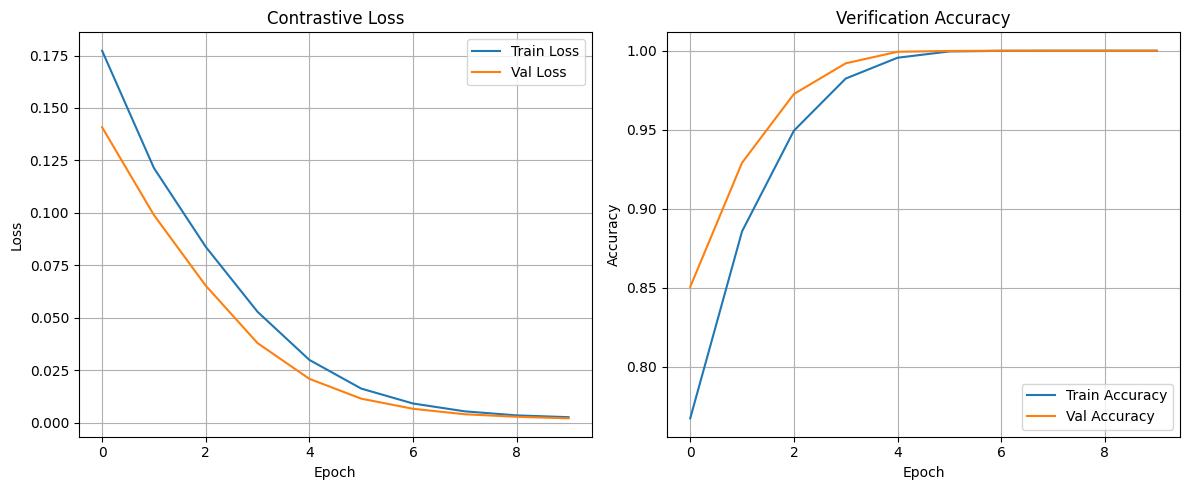

In [ ]:
# Plot the curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Contrastive Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Verification Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig("Loss and Accuracy Curves.png")
plt.show()

In [ ]:
def predict_HED_over_time(img1_path, img2_path, model, device, transform=None, threshold=0.5, alpha=10, beta=5):

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()])

    img1 = transform(Image.open(img1_path).convert("RGB")).unsqueeze(0).to(device)
    img2 = transform(Image.open(img2_path).convert("RGB")).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        emb1, emb2 = model(img1, img2)
        dist = F.pairwise_distance(emb1, emb2).item()
        prob = torch.sigmoid(torch.tensor(-alpha * dist + beta)).item()

    print(f"HED Model: Distance={dist:.4f}, Same probability={prob:.4f}")

    is_same = prob > 0.5

    fig, ax1 = plt.subplots(figsize=(8, 5))

    width = 0.3
    bar_positions = [0.3, 0.7]

    ax1.bar(bar_positions[0], dist, width, color='blue', label='Distance')
    ax1.set_ylabel('Distance', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    y_limit = 0.5
    ax1.set_ylim(0, y_limit)

    ax1.set_xticks(bar_positions)
    ax1.set_xticklabels(['Distance', 'Probability'])

    ax1.text(bar_positions[0], dist + y_limit * 0.02, f"{dist:.4f}", ha='center', va='bottom', color='blue')

    ax2 = ax1.twinx()
    ax2.bar(bar_positions[1], prob*100, width, color='orange', label='Probability')
    ax2.set_ylabel('Similarity (%)', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.set_ylim(0, 110)

    ax2.text(bar_positions[1], prob*100 + 3, f"{prob*100:.4f}%", ha='center', va='bottom', color='orange')

    plt.title('HED Model Prediction of Thatcher Illusion')
    plt.tight_layout()

    if os.path.exists("/content/drive"):
        save_dir = os.path.join("/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/HED", "predictions")
    else:
        save_dir = os.path.join(os.getcwd(), "output_images", "HED", "predictions")

    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"hed_prediction_Thatcher.png")
    plt.savefig(save_path, dpi=300)
    print(f"Saved prediction → {save_path}")

    plt.show()

    return is_same, dist, prob

HED Model: Distance=0.2800, Same probability=0.9002
Saved prediction → /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/HED/predictions/hed_prediction_Thatcher.png


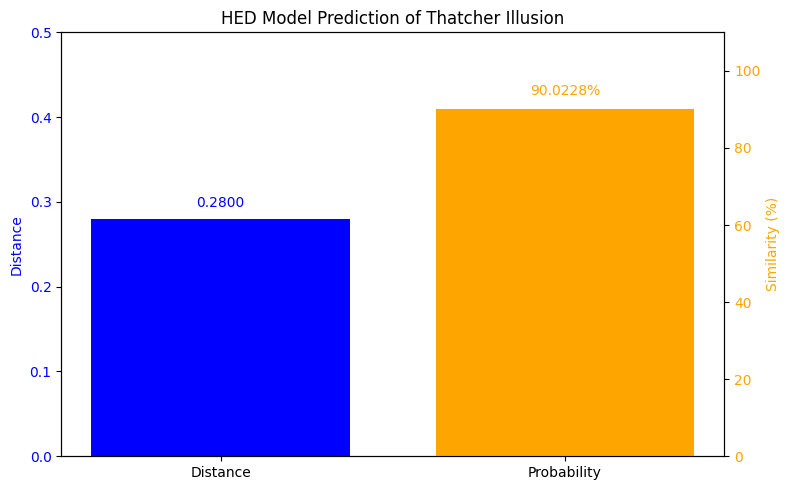

(True, 0.2800235152244568, 0.9002283811569214)

In [ ]:
predict_HED_over_time("/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Margaret Thatcher_test.jpg", "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Margaret Thatcher_test_n.jpg", model, device, threshold=0.5)
# predict_HED_over_time("/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Margaret Thatcher_test2.jpg", "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Margaret Thatcher_test_n2.jpg", model, device, threshold=0.5)
# predict_HED_over_time("/content/drive/MyDrive/NE240/Holistic Processing /First Experiment/Part_Whole_Illusion.jpg", "/content/drive/MyDrive/NE240/Holistic Processing /First Experiment/Part_Whole_Illusion_n.jpg", model, device, threshold=0.5)
# predict_HED_over_time("/content/drive/MyDrive/NE240/Holistic Processing /First Experiment/Part_Whole_Illusion2.jpg", "/content/drive/MyDrive/NE240/Holistic Processing /First Experiment/Part_Whole_Illusion_n2.jpg", model, device, threshold=0.5)

In [ ]:
def enhance_red_in_saliency(model, dataset, device, num_samples=10, top_percent=0.1, intensity=0.9, save_dir=None):
    model.eval()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    for i in range(num_samples):
        img1, _, _ = dataset[i]
        img1 = img1.unsqueeze(0).to(device).requires_grad_()

        out1, _ = model.forward(img1, img1)
        score = out1.norm()
        score.backward()

        saliency, _ = torch.max(img1.grad.data.abs(), dim=1)
        saliency = saliency[0].detach().cpu().numpy()

        flat_saliency = saliency.flatten()
        num_top_pixels = int(len(flat_saliency) * top_percent)
        threshold = np.partition(flat_saliency, -num_top_pixels)[-num_top_pixels]

        high_saliency_mask = saliency >= threshold

        img_np = img1[0].detach().cpu().permute(1, 2, 0).numpy()
        img_np = np.clip(img_np, 0, 1)

        saliency_norm = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-5)
        alpha = saliency_norm * intensity

        modified_img = img_np.copy()

        modified_img[..., 0] = modified_img[..., 0] + alpha * (1 - modified_img[..., 0])
        modified_img[..., 1] = modified_img[..., 1] * (1 - alpha)
        modified_img[..., 2] = modified_img[..., 2] * (1 - alpha)

        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

        axes[0].imshow(img_np)
        axes[0].set_title("Original")
        axes[0].axis("off")

        axes[1].imshow(modified_img)
        axes[1].set_title("Enhanced Red (Top 10% Saliency)")
        axes[1].axis("off")

        plt.tight_layout()

        if save_dir:
            save_path = os.path.join(save_dir, f"saliency_{i}.png")
            plt.savefig(save_path)
            print(f"Saved: {save_path}")

        plt.show()

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/HED/saliency_0.png


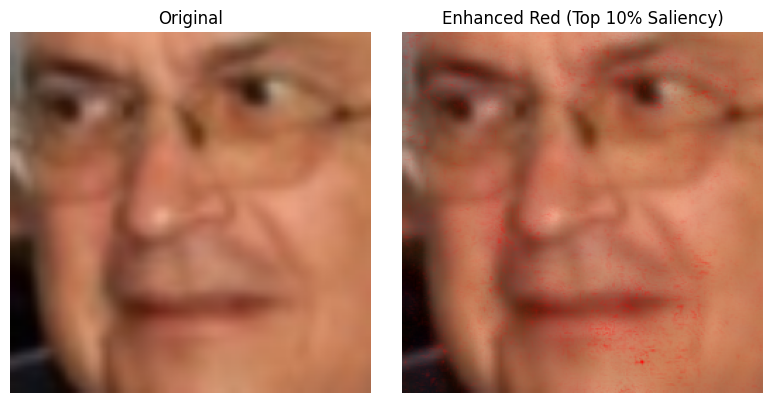

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/HED/saliency_1.png


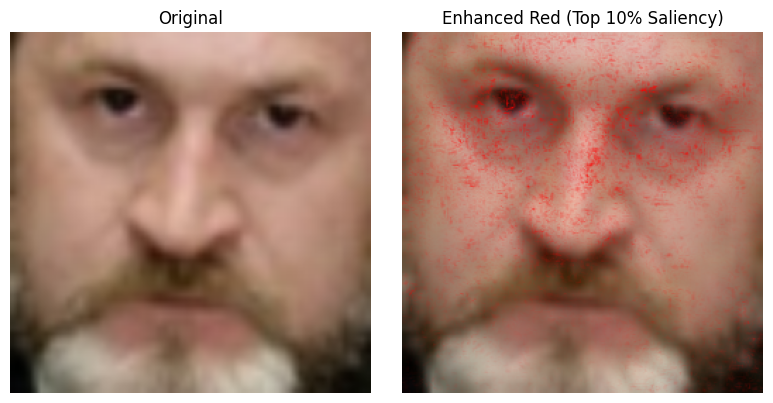

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/HED/saliency_2.png


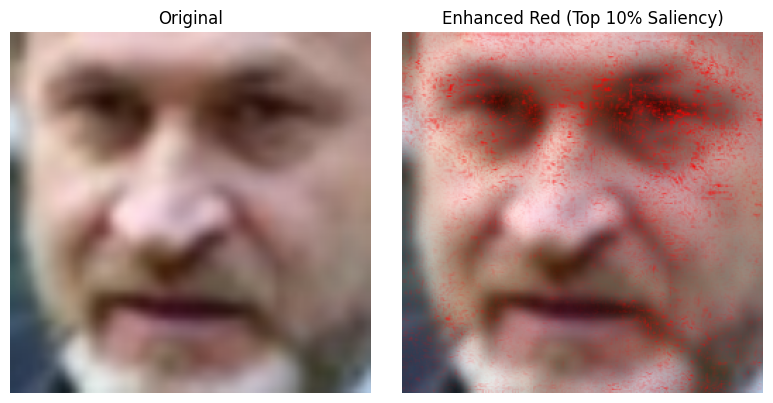

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/HED/saliency_3.png


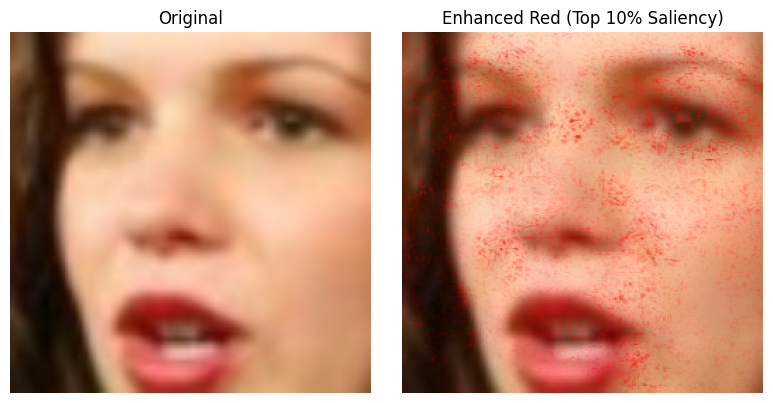

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/HED/saliency_4.png


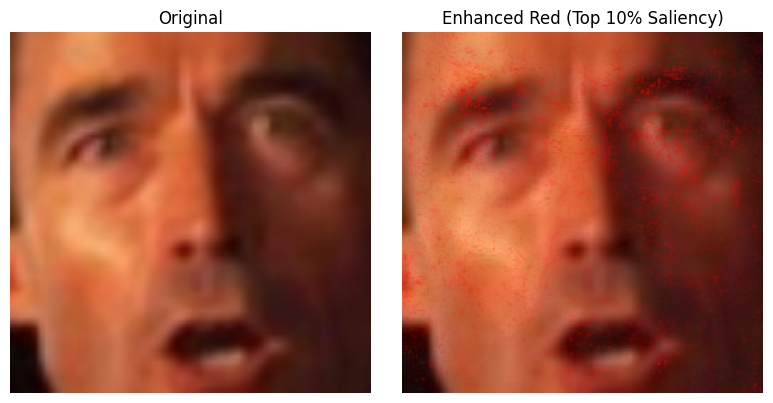

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/HED/saliency_5.png


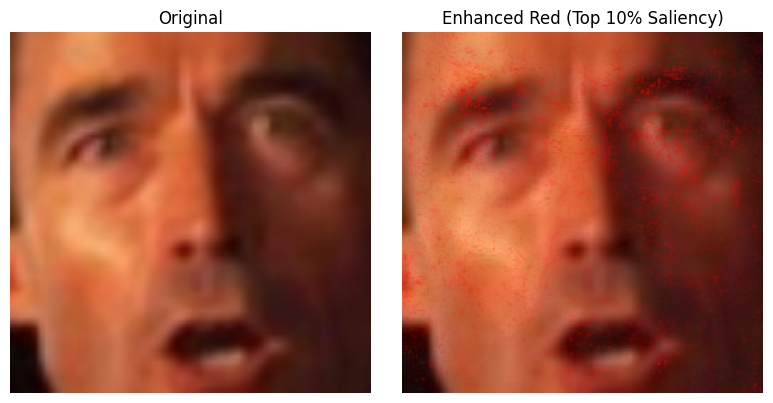

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/HED/saliency_6.png


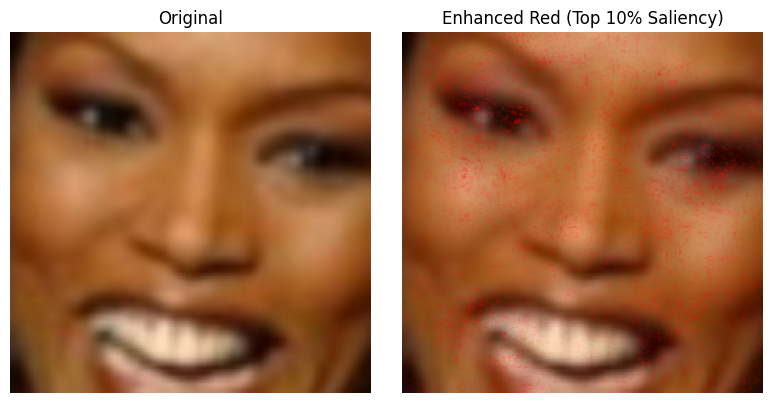

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/HED/saliency_7.png


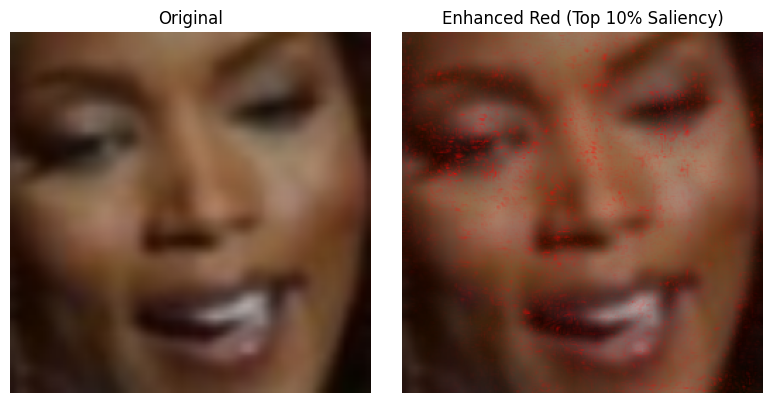

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/HED/saliency_8.png


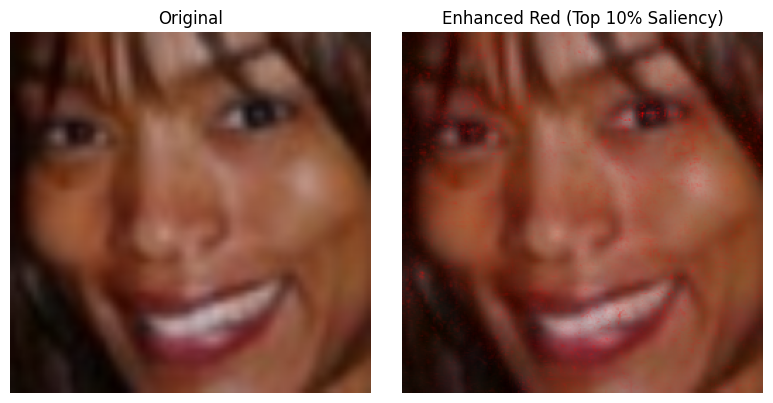

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/HED/saliency_9.png


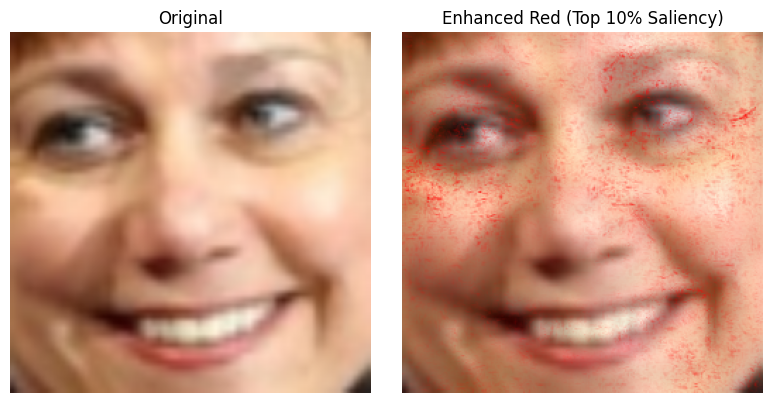

In [ ]:
enhance_red_in_saliency(model, val_dataset, device, num_samples=10, save_dir="/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/HED")

In [ ]:
# This saves model
import os
import torch
from datetime import datetime

model_name = "ResNet50"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = f"/content/drive/MyDrive/NE240/Holistic Processing /Forth Experiment/HED/{model_name}_{timestamp}"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "model.pt")
torch.save(model, model_path)

weights_path = os.path.join(save_dir, "weights.pt")
torch.save(model.state_dict(), weights_path)

config = {
    "model_name": model_name,
    "input_size": [3, 224, 224],
    "output_size": model.output_size if hasattr(model, "output_size") else None,
    "timestamp": timestamp,
    "description": "HED model trained on face recognition task"
}

import json
with open(os.path.join(save_dir, "config.json"), "w") as f:
    json.dump(config, f, indent=4)

print(f"模型已保存到目录: {save_dir}")

模型已保存到目录: /content/drive/MyDrive/NE240/Holistic Processing /Forth Experiment/HED/ResNet50_20250505_044256


In [ ]:
# This shows the size of model and # of parameters
def count_parameters(model):

    total_params = sum(p.numel() for p in model.parameters())

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f'总参数数量: {total_params:,}')
    print(f'可训练参数数量: {trainable_params:,}')
    print(f'固定参数数量: {total_params - trainable_params:,}')
    print(f'参数内存占用 (MB): {total_params * 4 / (1024 * 1024):.2f}')

    return total_params, trainable_params

total, trainable = count_parameters(model)

with open(f'{save_dir}/model_parameters.txt', 'w') as f:
    f.write(f'总参数数量: {total:,}\n')
    f.write(f'可训练参数数量: {trainable:,}\n')
    f.write(f'固定参数数量: {total - trainable:,}\n')
    f.write(f'参数内存占用 (MB): {total * 4 / (1024 * 1024):.2f}\n')

print('参数信息已保存到 model_parameters.txt')

总参数数量: 14,780,352
可训练参数数量: 14,780,352
固定参数数量: 0
参数内存占用 (MB): 56.38
参数信息已保存到 model_parameters.txt
